In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set the style for the plots
sns.set_palette("viridis")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams['axes.grid'] = True

import sys

src_root = os.path.abspath(os.path.join(os.getcwd(), '../src'))
if src_root not in sys.path:
    sys.path.append(src_root)

In [130]:
# Load the external dataset
def load_data(filepath, name):
    df = pd.read_csv(filepath)
    print(f"{name} data loaded successfully with {df.shape[0]} rows and {df.shape[1]} columns.")
    return df

external = load_data("../data/interim/cleaned_external_data.csv", "external")
augmented = load_data("../data/interim/augmented_data.csv", "augmented")

external data loaded successfully with 2029 rows and 3 columns.
augmented data loaded successfully with 10145 rows and 3 columns.


# Exploratory Data Analysis


## Data Summary


In [131]:
from scipy.stats import skew, kurtosis

### External Data

In [132]:
# Get the descriptive statistics
summary = external.describe()
# Calculate skewness and kurtosis for each column
summary.loc['skew'] = external.skew()
summary.loc['kurtosis'] = external.kurtosis()

# Display the updated summary
summary

,Tg,Ta,Tc
count,2029.000000,2029.000000,2029.000000
mean,34.368379,24.107541,37.029428
std,0.738554,1.324160,0.510204
min,30.225000,20.200000,35.540000
25%,33.955000,23.400000,36.790000
50%,34.387500,24.000000,36.940000
75%,34.787500,24.700000,37.140000
max,37.693333,29.100000,40.340000
skew,-0.202772,0.496327,1.972605
kurtosis,1.968662,1.342465,6.772299


In [133]:
from eda import dataframe_summary

# Get the detailed summary
dataframe_summary(external)


--- Dataframe Summary ---


,Data Type,Non-Null Count,Missing Values,Distinct Values,Zeros Count,Negative Values,Infinite Values
Tg,float64,2029,0,1215,0,0,0
Ta,float64,2029,0,78,0,0,0
Tc,float64,2029,0,70,0,0,0


### Augmented Data

In [136]:
summary = augmented.describe()
# Calculate skewness and kurtosis for each column
summary.loc['skew'] = augmented.skew()
summary.loc['kurtosis'] = augmented.kurtosis()

# Display the updated summary
summary

,Tg,Ta,Tc
count,10145.000000,10145.000000,10145.000000
mean,34.372229,24.099227,37.039149
std,0.693599,1.304977,0.526662
min,31.280000,20.200000,35.540000
25%,33.989256,23.400000,36.763354
50%,34.377622,24.000000,36.940000
75%,34.773112,24.700000,37.140000
max,37.212500,29.100000,40.340000
skew,-0.175914,0.536874,2.030711
kurtosis,2.119772,1.438873,7.075586


In [137]:
dataframe_summary(augmented)


--- Dataframe Summary ---


,Data Type,Non-Null Count,Missing Values,Distinct Values,Zeros Count,Negative Values,Infinite Values
Tg,float64,10145,0,10140,0,0,0
Ta,float64,10145,0,6666,0,0,0
Tc,float64,10145,0,5087,0,0,0


## Distribution Analysis


### External Data

In [41]:
from eda import distribution_analysis


--- Distribution Analysis ---

Normality Tests (Shapiro-Wilk):
{'Shapiro-Wilk Test': {'statistic': np.float64(0.9793508289116051), 'p/critical value': np.float64(1.501289877377752e-16), 'normal': np.False_}, "D'Agostino's K^2 Test": {'statistic': np.float64(108.83800294887938), 'p/critical value': np.float64(2.323421206512464e-24), 'normal': np.False_}, 'Anderson-Darling Test': {'statistic': np.float64(9.462656847499602), 'p/critical value': np.float64(0.785), 'normal': False}, 'conclusion': np.False_}
  The distribution of Tg is likely not normal (p < 0.05)
{'Shapiro-Wilk Test': {'statistic': np.float64(0.9646071877879414), 'p/critical value': np.float64(6.830884892878057e-22), 'normal': np.False_}, "D'Agostino's K^2 Test": {'statistic': np.float64(135.2831013551974), 'p/critical value': np.float64(4.203855633789137e-30), 'normal': np.False_}, 'Anderson-Darling Test': {'statistic': np.float64(26.40050226495441), 'p/critical value': np.float64(0.785), 'normal': False}, 'conclusion': n

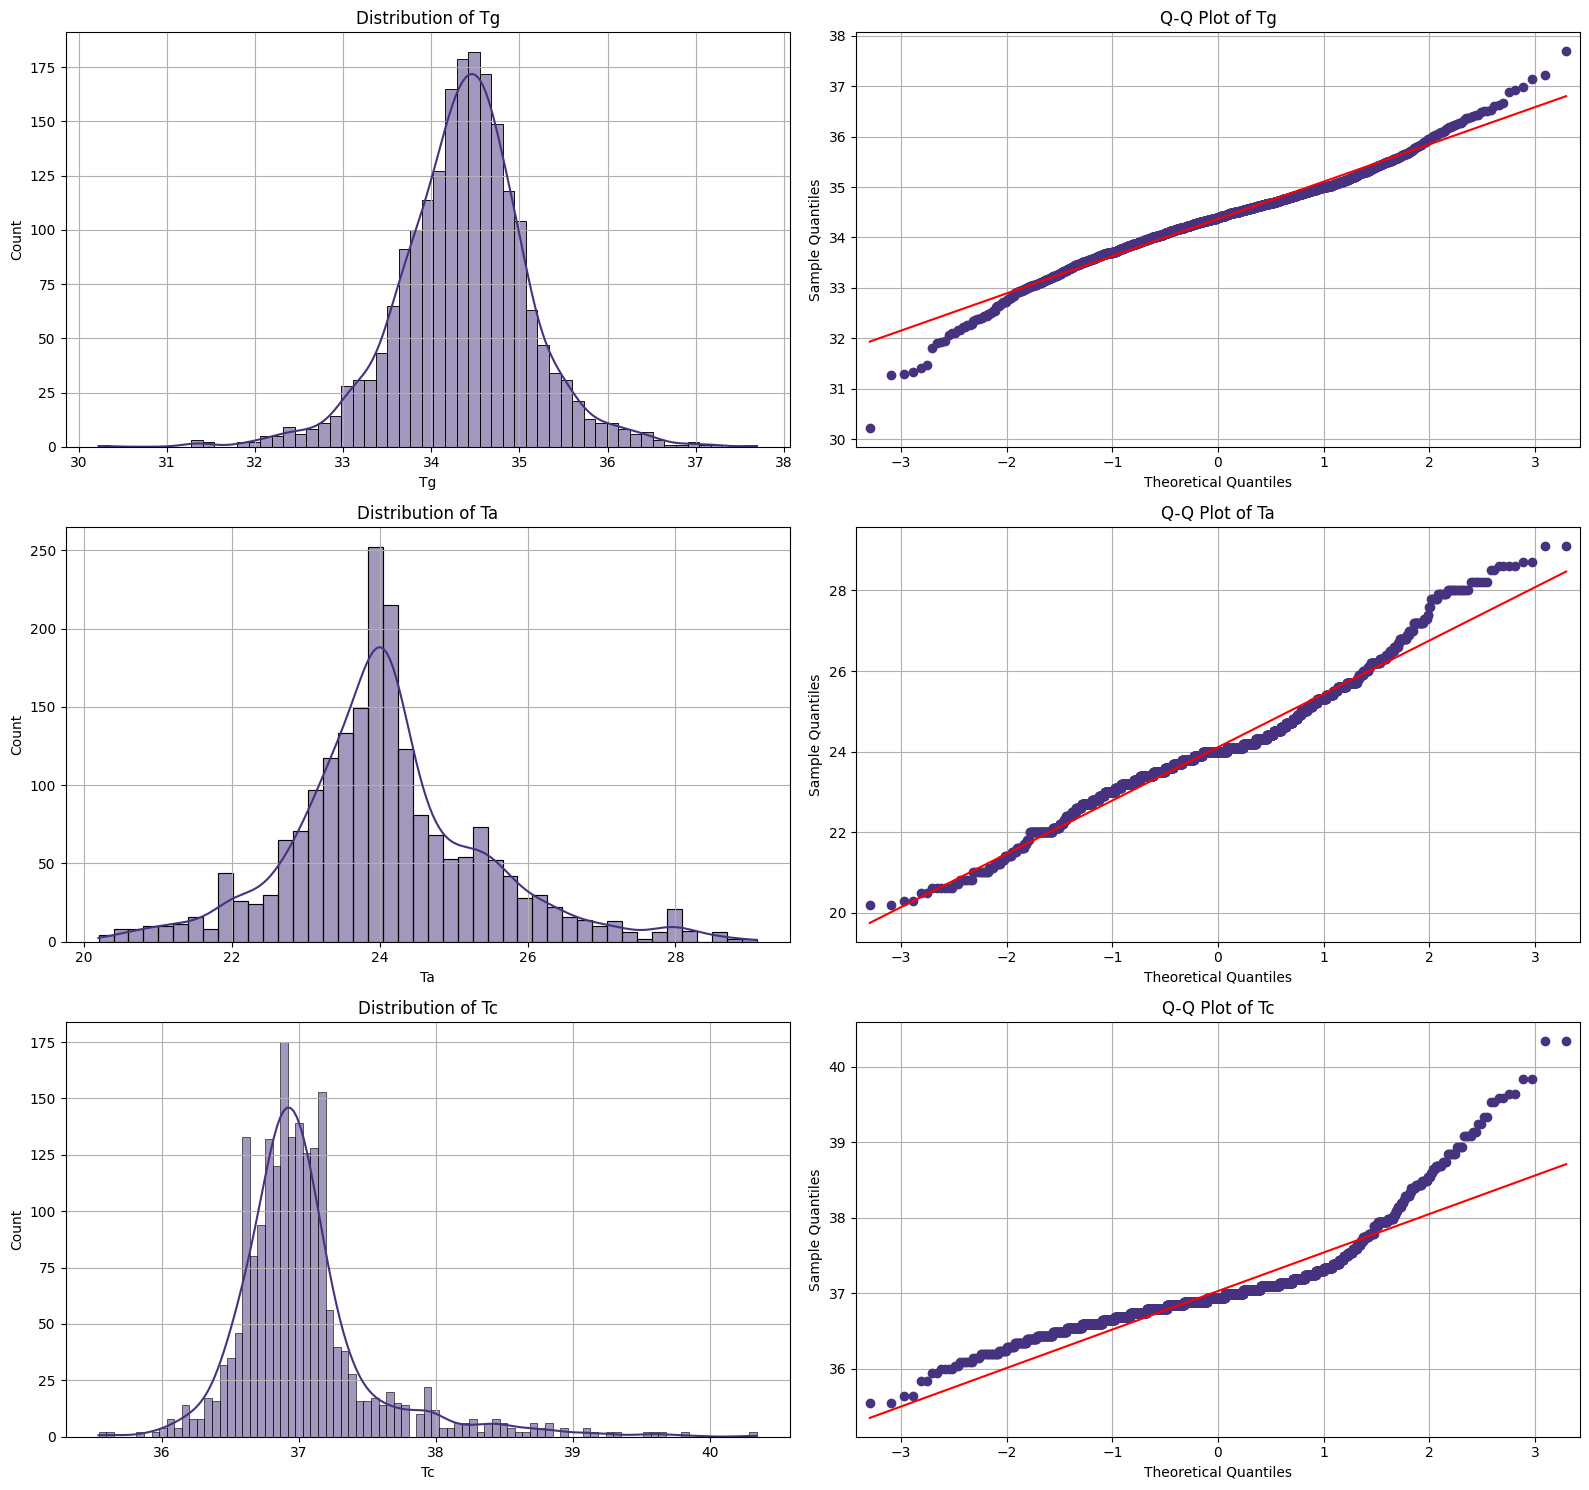

In [4]:
distribution_analysis(external, 'non_processed', 'external')

### Augmented Data


--- Distribution Analysis ---

Normality Tests (Shapiro-Wilk):
{'Shapiro-Wilk Test': {'statistic': np.float64(0.9777416561340792), 'p/critical value': np.float64(2.76096294212237e-27), 'normal': np.False_}, "D'Agostino's K^2 Test": {'statistic': np.float64(247.16017253624162), 'p/critical value': np.float64(2.137226057876191e-54), 'normal': np.False_}, 'Anderson-Darling Test': {'statistic': np.float64(21.154364222298682), 'p/critical value': np.float64(0.786), 'normal': False}, 'conclusion': np.False_}
  The distribution of Tg is likely not normal (p < 0.05)
{'Shapiro-Wilk Test': {'statistic': np.float64(0.9657165969554471), 'p/critical value': np.float64(6.679989550037237e-33), 'normal': np.False_}, "D'Agostino's K^2 Test": {'statistic': np.float64(374.8167411712617), 'p/critical value': np.float64(4.0698536471668844e-82), 'normal': np.False_}, 'Anderson-Darling Test': {'statistic': np.float64(59.80273254370695), 'p/critical value': np.float64(0.786), 'normal': False}, 'conclusion': 

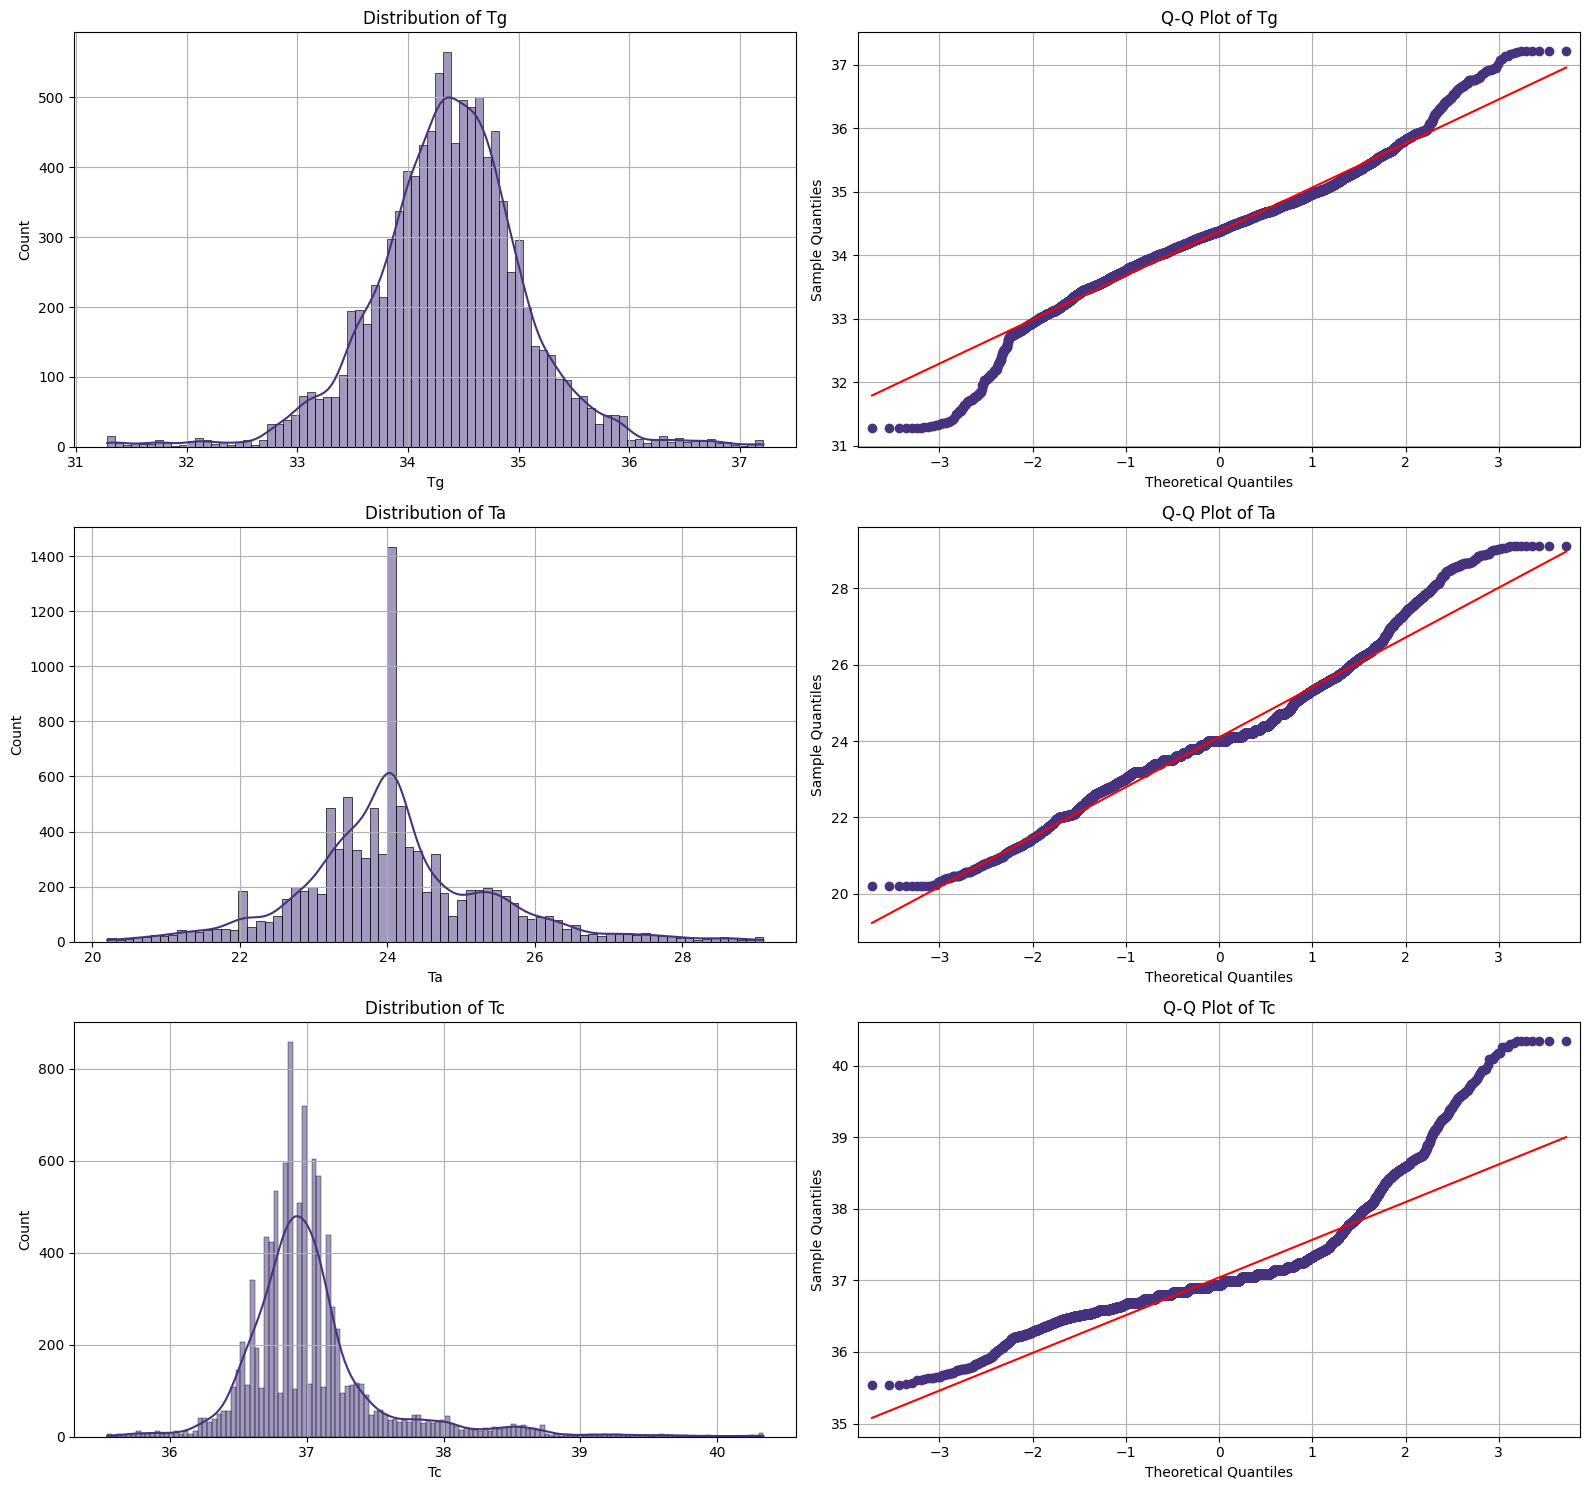

In [5]:
distribution_analysis(augmented, 'non_processed', 'augmented')

## Correlation Analysis


### External Data

In [134]:
from eda import correlation_analysis


--- Correlation Analysis ---

Correlation Matrix:
       Tg     Ta     Tc
Tg  1.000  0.355  0.548
Ta  0.355  1.000  0.098
Tc  0.548  0.098  1.000

Pearson Correlation Coefficients:
Tg vs Tc: r = 0.5482, p-value = 1.6529e-159
  The correlation between Tg and Tc is statistically significant
Ta vs Tc: r = 0.0976, p-value = 1.0718e-05
  The correlation between Ta and Tc is statistically significant

Spearman Rank Correlation Coefficients:
Tg vs Tc: rho = 0.4274, p-value = 6.4331e-91
Ta vs Tc: rho = 0.1016, p-value = 4.5605e-06


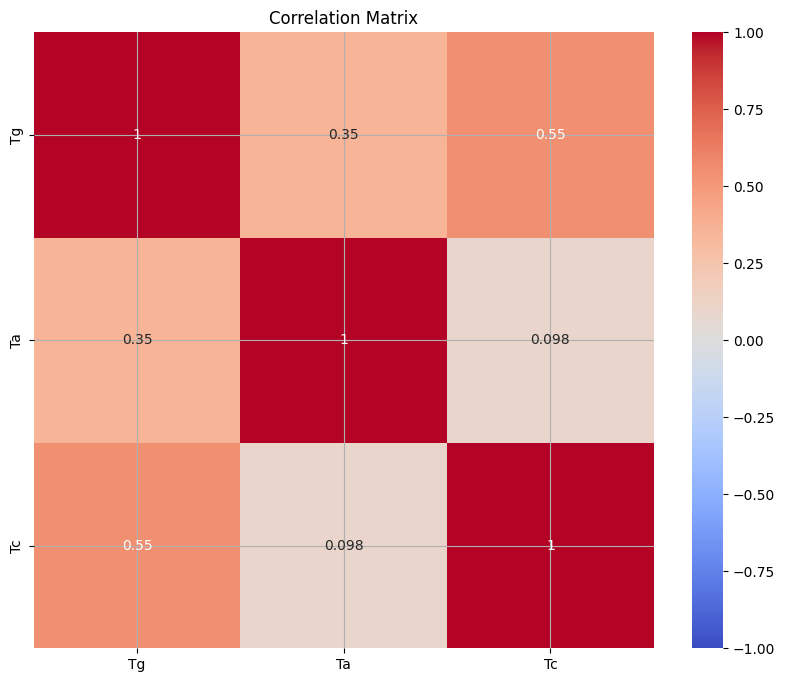

<Figure size 1500x1000 with 0 Axes>

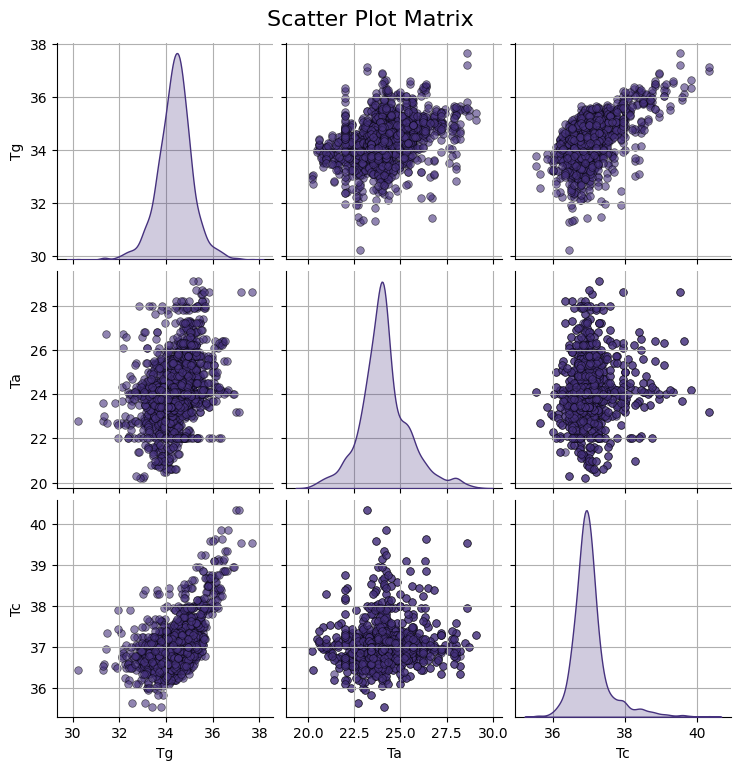

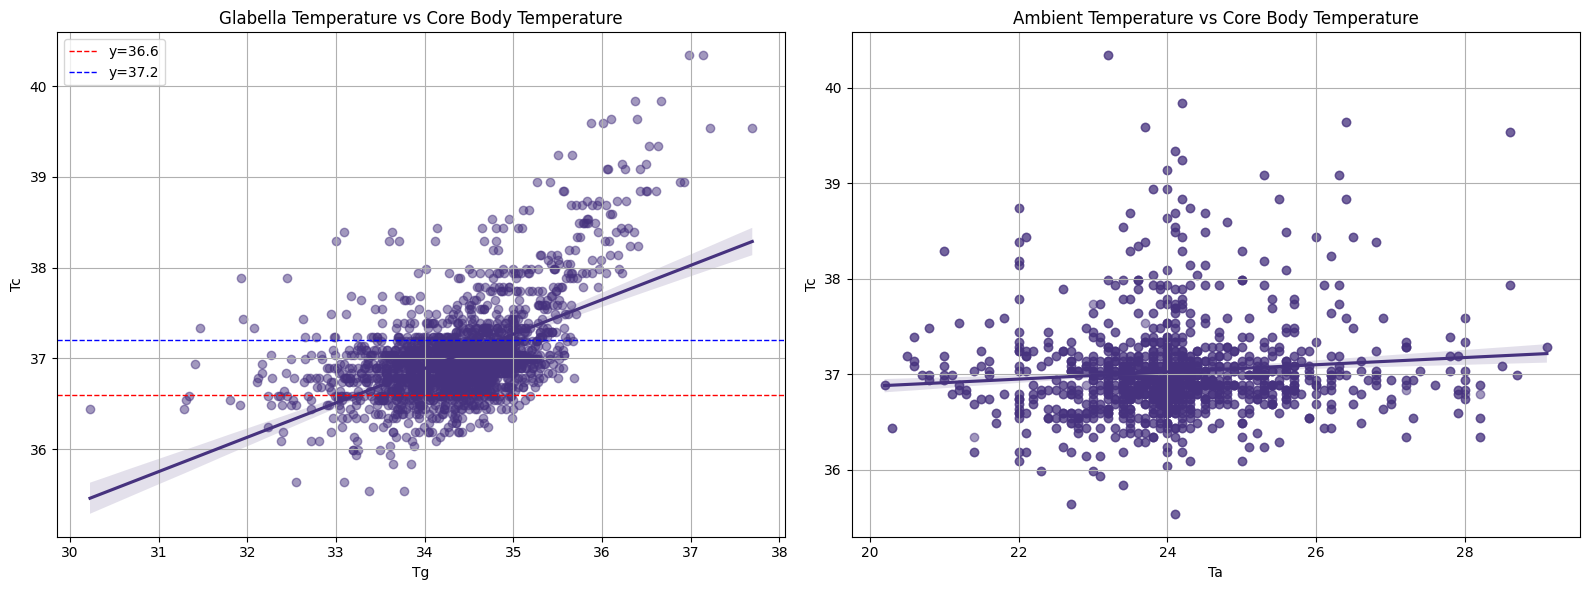

In [135]:
correlation_analysis(external, 'external')

### Augmented Data


--- Correlation Analysis ---

Correlation Matrix:
       Tg     Ta     Tc
Tg  1.000  0.363  0.545
Ta  0.363  1.000  0.103
Tc  0.545  0.103  1.000

Pearson Correlation Coefficients:
Tg vs Tc: r = 0.5447, p-value = 0.0000e+00
  The correlation between Tg and Tc is statistically significant
Ta vs Tc: r = 0.1034, p-value = 1.5780e-25
  The correlation between Ta and Tc is statistically significant

Spearman Rank Correlation Coefficients:
Tg vs Tc: rho = 0.4277, p-value = 0.0000e+00
Ta vs Tc: rho = 0.0996, p-value = 8.7398e-24


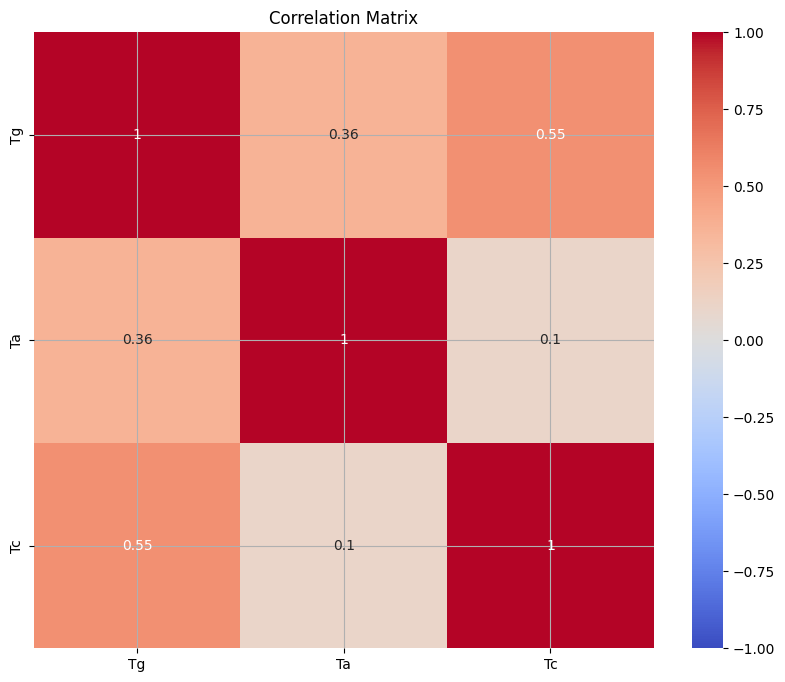

<Figure size 1500x1000 with 0 Axes>

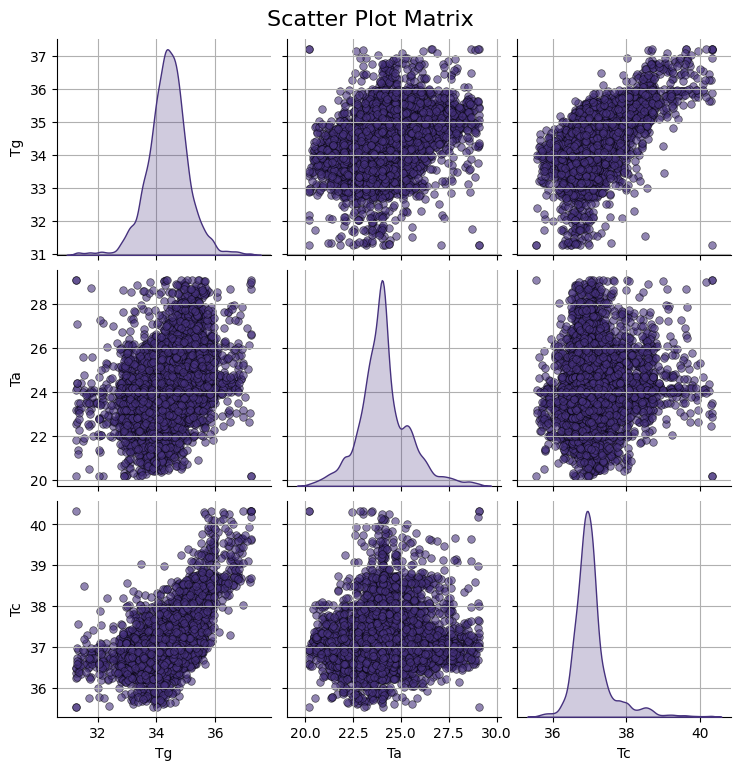

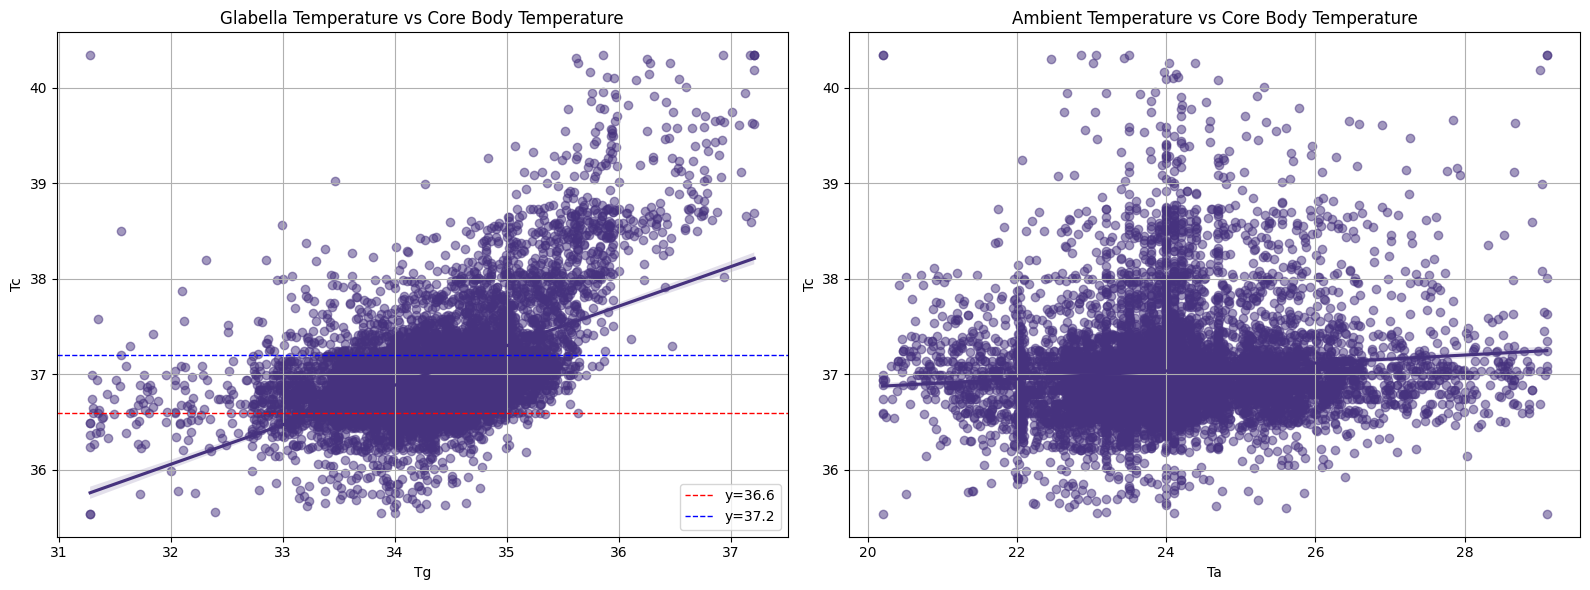

In [138]:
correlation_analysis(augmented, 'augmented')

## Outlier Analysis


Normal body temperature is considered to be **36. 6°C** to **37. 2°C** or 98-99°F. Any temperature higher than this range is considered to be fever. Note that evening temperature is higher than the normal.

Dr. Anet Varghese
4 years exp · India · Doctor Of Medicine (MBBS)


In [19]:
from eda import outlier_analysis

## External Data

In [ ]:
outlier_analysis(external)

#### Greater than 37.2


A temperature greater than 37.2 indicates fever data or higher-than-normal temperature records.


In [21]:
# ogtnt means "out of the normal temperature"
ogtnt = external[external['Tc'] > 37.2].copy() # Temperature greater than 37.2 degrees Celsius


--- Outlier Analysis ---

Tg - Outliers detected: 11
Lower bound: 32.88, Upper bound: 37.03
Outlier values:
[31.46333333 31.93       31.955      32.07       32.45       32.6225
 32.645      32.7725     37.13666667 37.2125     37.69333333]

Ta - Outliers detected: 20
Lower bound: 21.25, Upper bound: 27.25
Outlier values:
[20.6 20.8 21.  21.2 27.8 28.  28.6 29.1]

Tc - Outliers detected: 20
Lower bound: 36.37, Upper bound: 38.97
Outlier values:
[39.09 39.14 39.24 39.34 39.54 39.59 39.64 39.84 40.34]

Outlier detection using Z-scores (|z| > 3):
Tg: 5 outliers detected by Z-score method
Ta: 6 outliers detected by Z-score method
Tc: 10 outliers detected by Z-score method


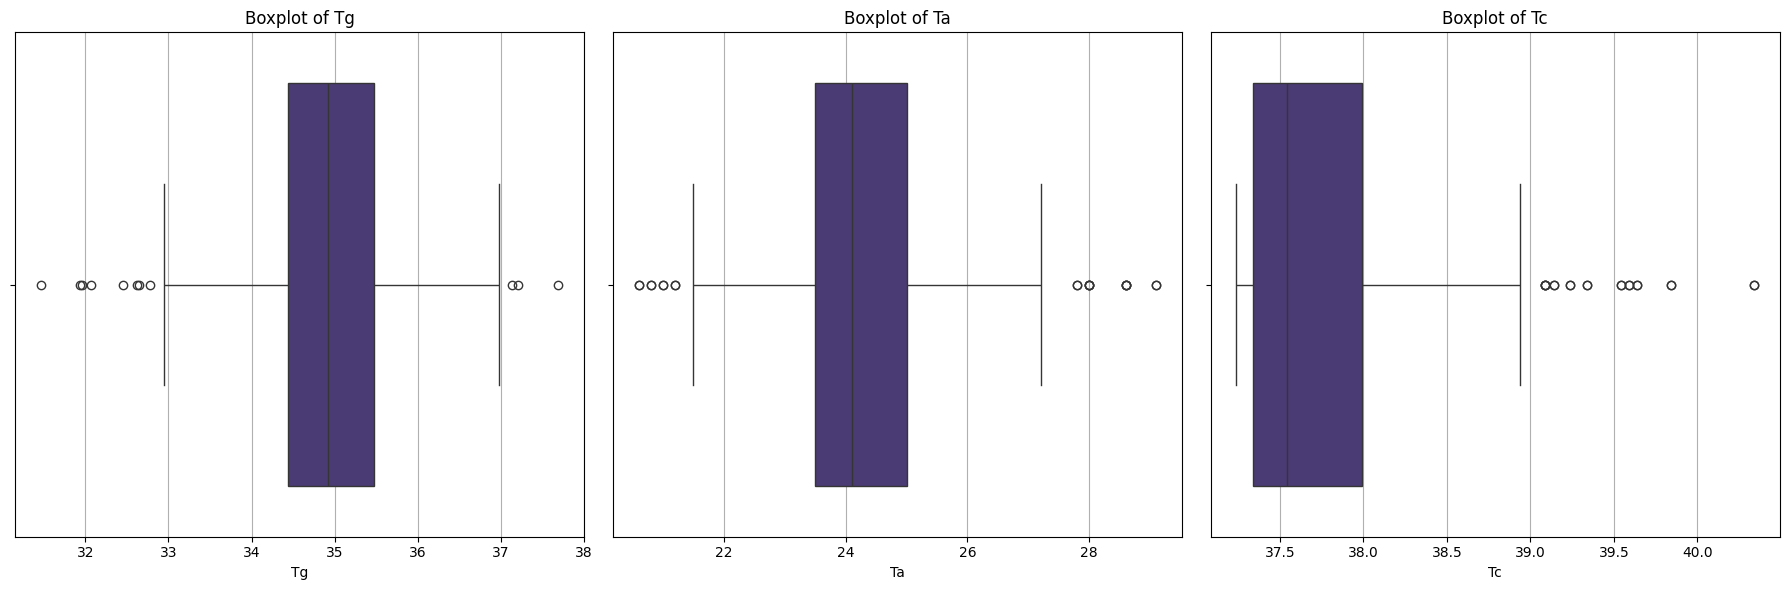

In [22]:
ogt_outliers = outlier_analysis(ogtnt)

In [23]:
ogt_outliers['Tg'][ogt_outliers['Tg']['Tg'] < 32.88]

# Fail
# Assumed cold ambient temperature affected core body temperature or subjects had fever

,Tg,Ta,Tc
215,32.070000,22.7,37.34
272,32.450000,22.6,37.89
624,32.622500,22.0,37.44
1238,31.463333,22.7,37.34
1292,31.930000,22.6,37.89
1632,31.955000,22.0,37.44
1922,32.772500,23.9,37.24
1933,32.645000,23.8,37.24


In [24]:
ogt_outliers['Tc'][ogt_outliers['Tc']['Tc'] > 38.97]

# To keep

,Tg,Ta,Tc
122,36.975000,23.2,40.34
156,36.105000,26.4,39.64
490,36.425000,26.3,39.09
645,36.367500,24.2,39.84
648,35.877500,23.7,39.59
712,36.530000,24.1,39.34
761,36.227500,24.0,39.14
799,37.212500,28.6,39.54
839,36.065000,25.3,39.09
845,35.655000,24.2,39.24


In [25]:
modified_ogtnt = ogtnt[~ogtnt.index.isin(ogtnt[(ogtnt['Tg'] >= 33) & (ogtnt['Tg'] <= 34) & (ogtnt['Tc'] >= 38)].index)]
modified_ogtnt = modified_ogtnt[~modified_ogtnt.index.isin(ogt_outliers['Tg'][ogt_outliers['Tg']['Tg'] < 32.88].index)]

#### Within 36.6 to 37.2 Range


A temperature within the range of 36.6 to 37.2 degrees is often considered typical for the human body.


In [26]:
# ont means "on the normal temperature"
ont = external[(external['Tc'] >= 36.6) & (external['Tc'] <= 37.2)].copy()


--- Outlier Analysis ---

Tg - Outliers detected: 28
Lower bound: 32.95, Upper bound: 35.73
Outlier values:
[31.4125     32.11333333 32.115      32.1675     32.2625     32.2775
 32.4125     32.435      32.49       32.53       32.63333333 32.65
 32.6675     32.70666667 32.72       32.77       32.785      32.8025
 32.83       32.835      32.84       32.8925     32.895      32.9175
 32.92       32.9425     32.945     ]

Ta - Outliers detected: 111
Lower bound: 21.70, Upper bound: 26.50
Outlier values:
[20.2 20.5 20.6 20.7 20.8 21.  21.1 21.2 21.3 21.4 21.5 21.6 26.6 26.7
 26.8 26.9 27.  27.2 27.3 27.4 27.6 27.8 27.9 28.  28.2 28.5 28.7]

Tc - Outliers detected: 0
Lower bound: 36.41, Upper bound: 37.41

Outlier detection using Z-scores (|z| > 3):
Tg: 11 outliers detected by Z-score method
Ta: 18 outliers detected by Z-score method
Tc: 0 outliers detected by Z-score method


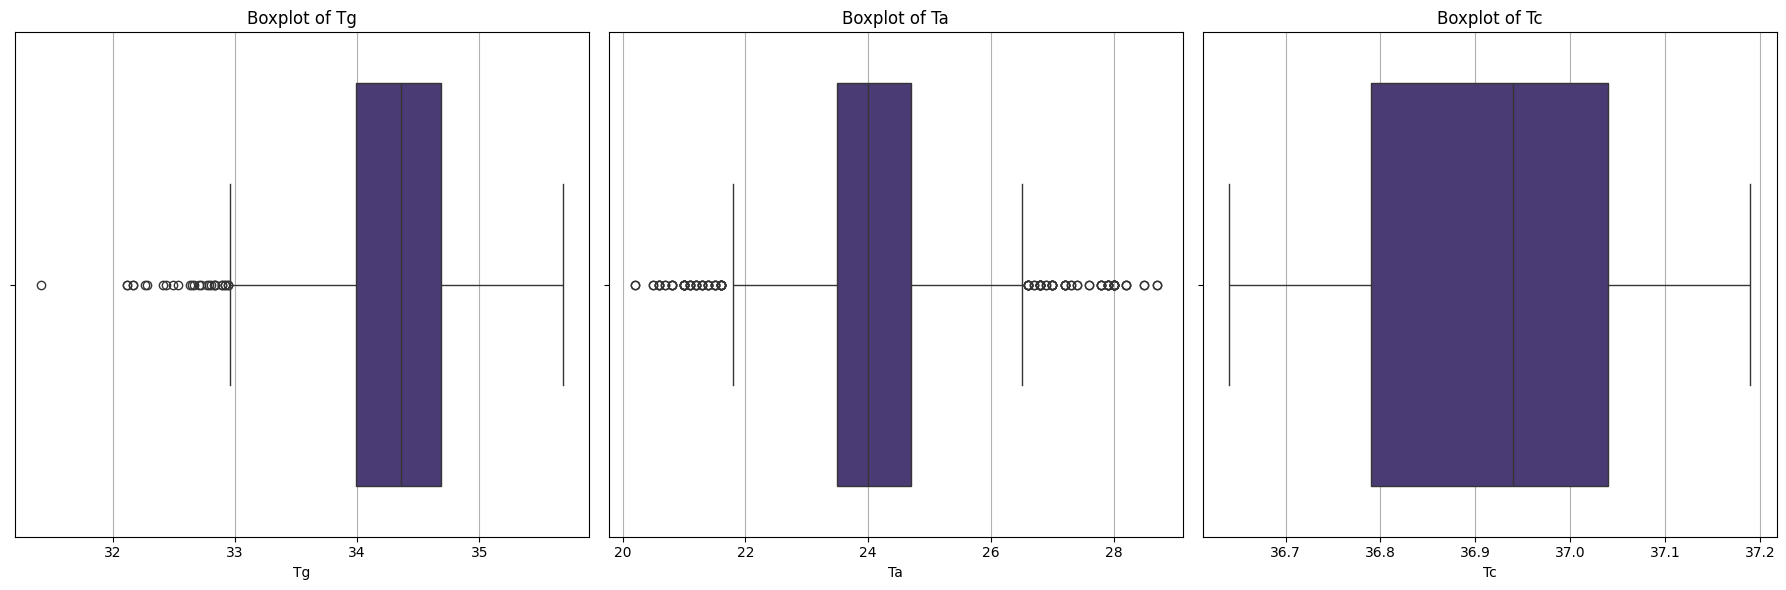

In [27]:
ont_outliers = outlier_analysis(ont)

In [28]:
ont_outliers['Tg'][ont_outliers['Tg']['Tg'] < 32.95]

# Fail

,Tg,Ta,Tc
74,32.530000,23.7,36.79
303,32.167500,26.7,36.94
374,32.785000,21.4,36.69
654,32.942500,23.8,36.64
813,32.892500,24.4,36.79
921,32.840000,23.5,36.99
1034,32.945000,23.0,36.74
1097,32.115000,23.7,36.79
1146,32.650000,22.8,36.99
1181,32.167500,26.1,36.84


In [29]:
ont_outliers['Tg'][ont_outliers['Tg']['Tg'] > 35.73]

# Fail

,Tg,Ta,Tc


In [30]:
modified_ont = ont[~ont.index.isin(ont_outliers['Tg'][ont_outliers['Tg']['Tg'] < 32.95].index)]
modified_ont = modified_ont[~modified_ont.index.isin(ont_outliers['Tg'][ont_outliers['Tg']['Tg'] > 35.73].index)]

#### Lower than 36.6


A temperature lower than 36.6 indicates lower-than-normal temperature records.


In [31]:
# oltnt means "on low than normal temperature"
oltnt = external[external['Tc'] < 36.6].copy()


--- Outlier Analysis ---

Tg - Outliers detected: 6
Lower bound: 32.21, Upper bound: 35.64
Outlier values:
[30.225  31.28   31.3025 31.34   31.8075 31.9125]

Ta - Outliers detected: 14
Lower bound: 20.70, Upper bound: 26.30
Outlier values:
[20.3 26.6 27.2 27.3 27.9 28.2]

Tc - Outliers detected: 8
Lower bound: 35.97, Upper bound: 36.97
Outlier values:
[35.54 35.64 35.84 35.94]

Outlier detection using Z-scores (|z| > 3):
Tg: 4 outliers detected by Z-score method
Ta: 6 outliers detected by Z-score method
Tc: 6 outliers detected by Z-score method


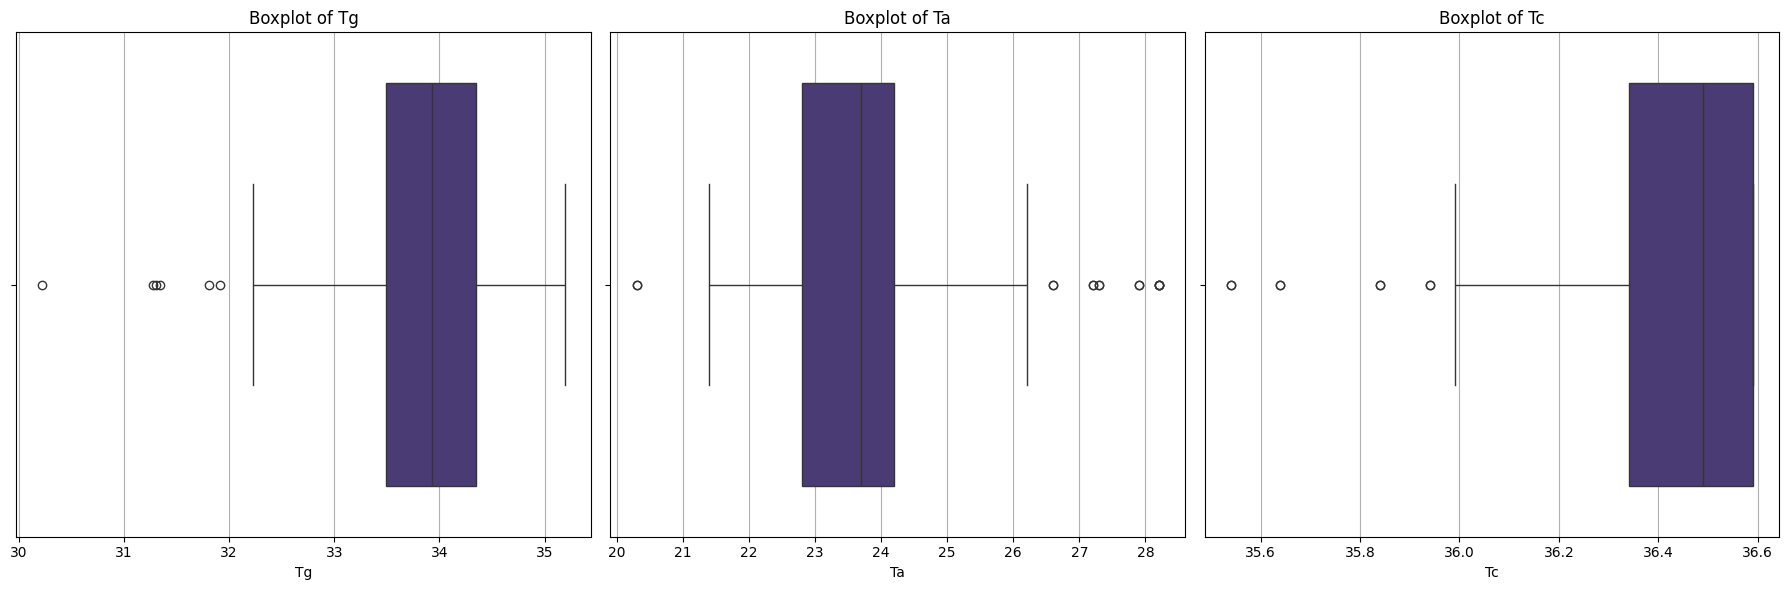

In [32]:
olt_outliers = outlier_analysis(oltnt)

In [33]:
olt_outliers['Tg'][olt_outliers['Tg']['Tg'] < 32.21]

#  Fail

,Tg,Ta,Tc
166,31.2800,22.8,36.44
613,31.8075,23.6,36.54
1122,31.9125,22.7,36.49
1189,30.2250,22.8,36.44
1252,31.3400,23.0,36.59
1621,31.3025,23.6,36.54


In [34]:
olt_outliers['Tc'][olt_outliers['Tc']['Tc'] < 35.97]
 
# Fail

,Tg,Ta,Tc
112,33.092500,22.7,35.64
171,33.610000,23.1,35.94
477,33.850000,23.4,35.84
674,33.767500,24.1,35.54
1134,32.543333,22.7,35.64
1194,33.230000,23.1,35.94
1493,33.646667,23.4,35.84
1682,33.376667,24.1,35.54


In [35]:
modified_oltnt = oltnt[~oltnt.index.isin(olt_outliers['Tg'][olt_outliers['Tg']['Tg'] < 32.21].index)]
modified_oltnt = modified_oltnt[~modified_oltnt.index.isin(olt_outliers['Tc'][olt_outliers['Tc']['Tc'] < 35.97].index)]

#### All (Exclude Outliers)


In [36]:
save_preprocess_data = pd.concat([modified_oltnt, modified_ont, modified_ogtnt], ignore_index=True)

In [37]:
# save_preprocess_data.to_csv("../data/interim/preprocessed_external_data.csv", index=False)

### Summary

In [38]:
summary = save_preprocess_data.describe()
# Calculate skewness and kurtosis for each column
summary.loc['skew'] = save_preprocess_data.skew()
summary.loc['kurtosis'] = save_preprocess_data.kurtosis()

# Display the updated summary
summary

,Tg,Ta,Tc
count,1974.000000,1974.000000,1974.000000
mean,34.418135,24.117021,37.033921
std,0.674742,1.316808,0.503735
min,32.227500,20.200000,35.990000
25%,34.003125,23.400000,36.790000
50%,34.418750,24.000000,36.940000
75%,34.800000,24.700000,37.140000
max,37.693333,29.100000,40.340000
skew,0.288564,0.502546,2.106629
kurtosis,1.179991,1.379529,7.177586


In [139]:
dataframe_summary(save_preprocess_data)


--- Dataframe Summary ---


,Data Type,Non-Null Count,Missing Values,Distinct Values,Zeros Count,Negative Values,Infinite Values
Tg,float64,1974,0,1170,0,0,0
Ta,float64,1974,0,77,0,0,0
Tc,float64,1974,0,66,0,0,0



--- Distribution Analysis ---

Normality Tests (Shapiro-Wilk):
{'Shapiro-Wilk Test': {'statistic': np.float64(0.9874251439345364), 'p/critical value': np.float64(3.9482401273257445e-12), 'normal': np.False_}, "D'Agostino's K^2 Test": {'statistic': np.float64(75.95876986988044), 'p/critical value': np.float64(3.204517861921281e-17), 'normal': np.False_}, 'Anderson-Darling Test': {'statistic': np.float64(5.029425545830009), 'p/critical value': np.float64(0.785), 'normal': False}, 'conclusion': np.False_}
  The distribution of Tg is likely not normal (p < 0.05)
{'Shapiro-Wilk Test': {'statistic': np.float64(0.9639195218084333), 'p/critical value': np.float64(8.626254100297591e-22), 'normal': np.False_}, "D'Agostino's K^2 Test": {'statistic': np.float64(135.4068000586339), 'p/critical value': np.float64(3.9517272448182954e-30), 'normal': np.False_}, 'Anderson-Darling Test': {'statistic': np.float64(25.918800859385556), 'p/critical value': np.float64(0.785), 'normal': False}, 'conclusion':

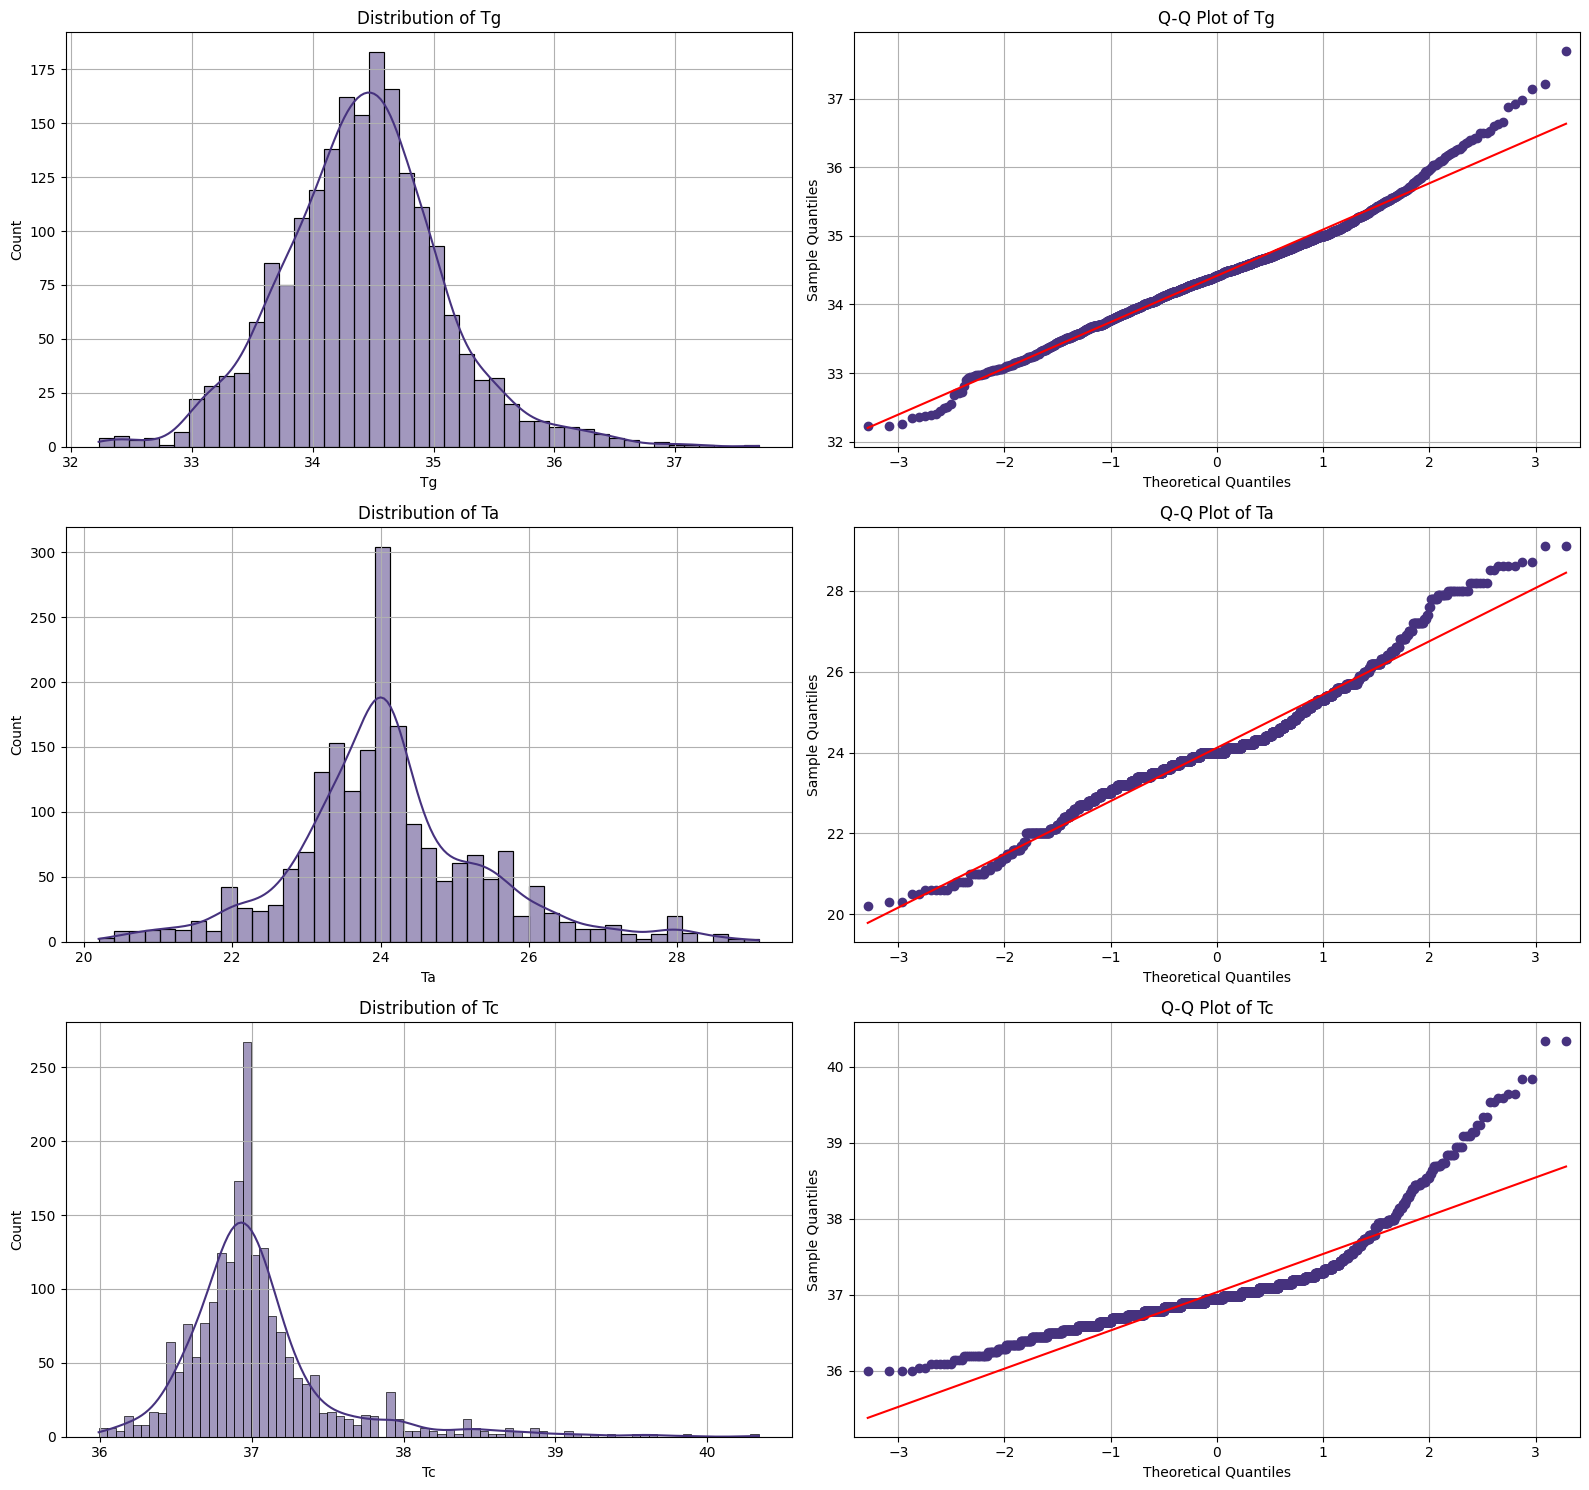

In [43]:
distribution_analysis(save_preprocess_data, 'preprocessed', 'external')

## Augmented Data

In [ ]:
outlier_analysis(augmented)

### Greater than 37.2

In [95]:
agtnt = augmented[augmented['Tc'] > 37.2].copy()


--- Outlier Analysis ---

Tg - Outliers detected: 40
Lower bound: 32.89, Upper bound: 36.91
Outlier values:
[31.28       31.35273437 31.55340279 31.55345262 31.63715755 31.84560579
 32.09810506 32.11711283 32.31952365 32.50897824 32.5144115  32.77857302
 32.78057673 32.81478613 32.85452378 32.85506657 32.85597324 32.87088674
 32.87745507 32.88896471 36.90992808 36.91955731 36.92260024 36.93664631
 36.94321461 36.94512525 37.0172549  37.07293293 37.0940763  37.13105276
 37.14009525 37.17491062 37.18164602 37.19603229 37.21242353 37.21244137
 37.2125    ]

Ta - Outliers detected: 169
Lower bound: 21.39, Upper bound: 26.98
Outlier values:
[20.2        20.41853755 20.45669418 20.46845751 20.47775453 20.48238371
 20.51305884 20.5560063  20.57632044 20.59139011 20.61178671 20.63778387
 20.63917796 20.64181825 20.7154935  20.71628437 20.72981804 20.74286467
 20.80929948 20.85034175 20.85621297 20.86615757 20.86936229 20.8716579
 20.89000858 20.89392307 20.91360528 20.91467139 20.92257863 20.

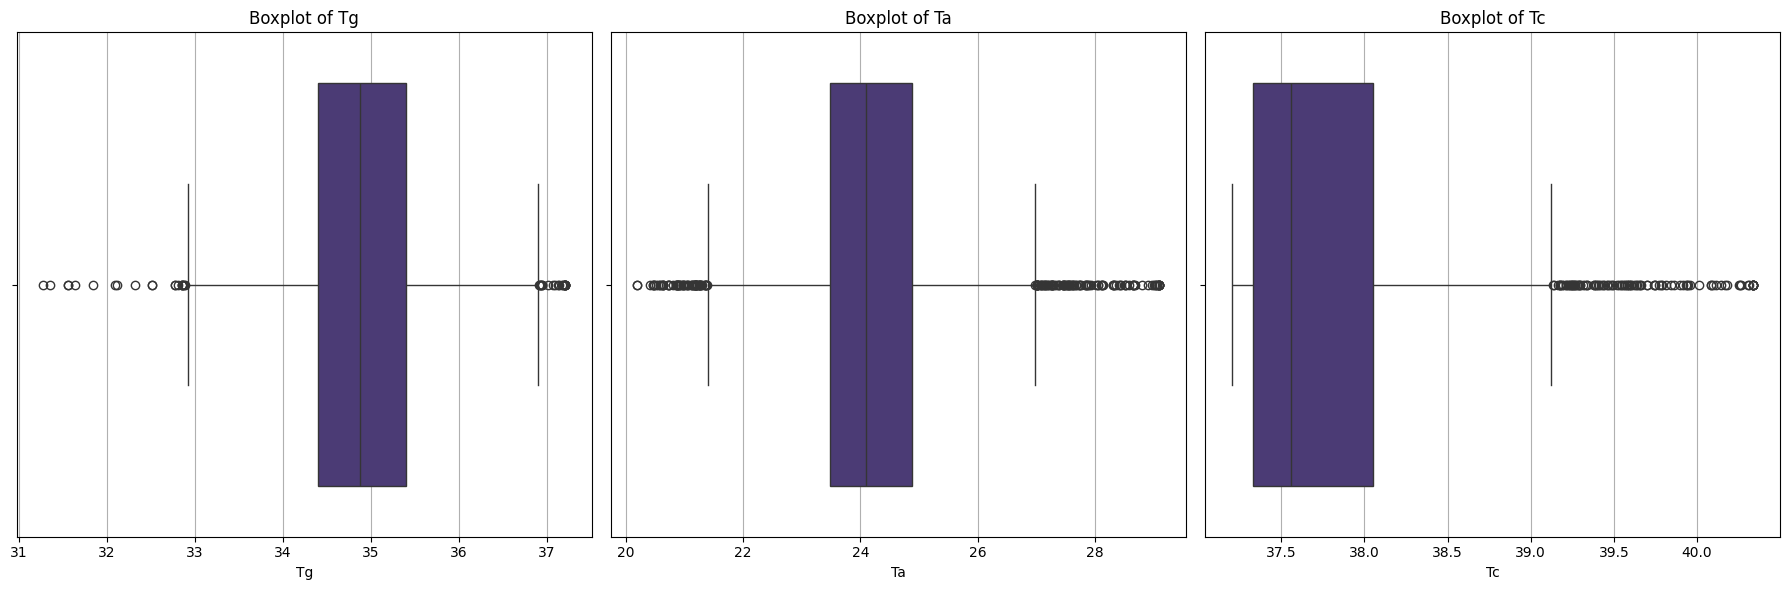

In [96]:
agt_outliers = outlier_analysis(agtnt)

In [97]:
agt_outliers['Tg'][agt_outliers['Tg']['Tg'] < 32.89]

# Fail
# Assumed cold ambient temp affected core body temperature

,Tg,Ta,Tc
454,32.508978,23.400000,37.518686
589,32.854524,25.809954,38.193433
1011,31.553403,24.118716,38.501772
1404,31.280000,29.100000,40.340000
2381,32.514411,22.475182,37.443945
2958,31.352734,21.199424,37.574567
3505,31.637158,23.650136,37.295408
4947,32.778573,22.004448,37.215631
5501,31.845606,22.022446,37.426588
6658,32.888965,20.715493,37.264938


In [98]:
agt_outliers['Tc'][agt_outliers['Tc']['Tc'] > 39.13]

# To keep

,Tg,Ta,Tc
184,35.937388,24.000000,39.521889
411,36.084109,24.209256,39.815855
506,37.131053,22.668144,39.941158
601,36.696118,23.039822,39.744647
632,36.410610,23.079045,39.466270
...,...,...,...
9781,35.422166,24.000000,39.282658
9815,35.976705,24.200000,39.899384
9828,35.826195,23.915967,39.603112
9922,36.480118,24.700000,39.268357


In [99]:
modified_agtnt = agtnt[~agtnt.index.isin(agtnt[(agtnt['Tg'] >= 32) & (agtnt['Tg'] <= 34) & (agtnt['Tc'] >= 38)].index)]
modified_agtnt = modified_agtnt[~modified_agtnt.index.isin(agt_outliers['Tg'][agt_outliers['Tg']['Tg'] < 32.89].index)]

### Within 36.6 and 37.2 range

In [100]:
ant = augmented[(augmented['Tc'] >= 36.6) & (augmented['Tc'] <= 37.2)].copy()


--- Outlier Analysis ---

Tg - Outliers detected: 131
Lower bound: 32.96, Upper bound: 35.71
Outlier values:
[31.2955138  31.29565697 31.30329112 31.34431855 31.35536444 31.42689698
 31.49498836 31.50961491 31.55044772 31.59741974 31.6599833  31.70908041
 31.72275415 31.72664245 31.74889801 31.76254879 31.77467766 31.78422582
 31.78954767 31.80321663 31.80971959 31.81234694 31.83279795 31.8455773
 31.88697254 31.96217244 31.96676741 32.03578079 32.03660326 32.04044323
 32.04240969 32.0883861  32.09030586 32.12246082 32.131154   32.13181891
 32.14798793 32.17413779 32.18650272 32.19339392 32.19798872 32.27662099
 32.28672979 32.29972631 32.32324063 32.34601853 32.42221343 32.44018784
 32.49802617 32.50341279 32.51666246 32.5218285  32.52421373 32.53866097
 32.55572599 32.55896825 32.62001009 32.65971098 32.67327742 32.68233923
 32.71896263 32.72444644 32.73191391 32.73663298 32.73991305 32.74033321
 32.74211828 32.74408517 32.74628813 32.75076567 32.75281197 32.75347305
 32.7579131  32

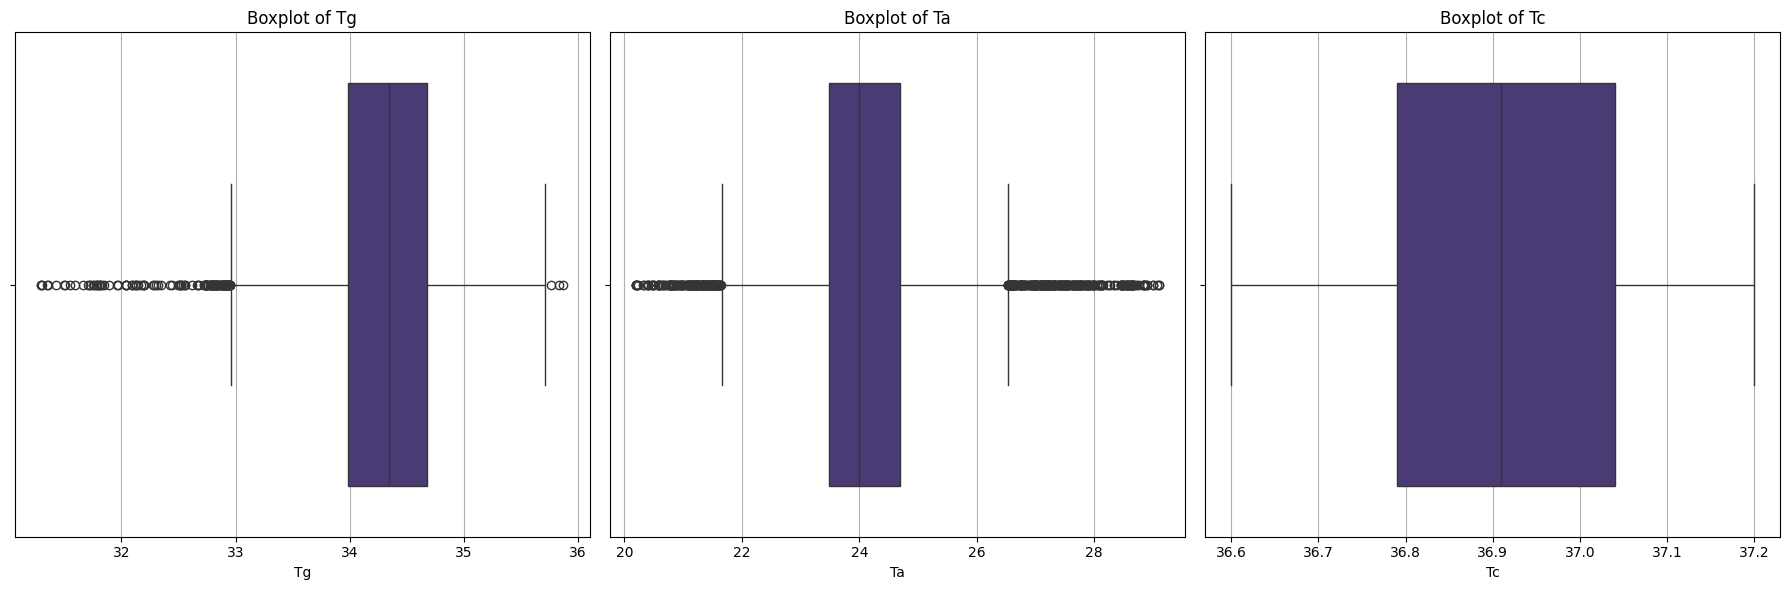

In [101]:
ant_outliers = outlier_analysis(ant)

In [102]:
ant_outliers['Tg'][ant_outliers['Tg']['Tg'] < 32.96]

# Fail

,Tg,Ta,Tc
3,32.718963,22.984982,37.140000
98,32.299726,24.370722,36.639557
229,31.774678,23.224068,36.622821
250,32.682339,25.129270,36.940000
386,32.951412,26.202531,37.040000
...,...,...,...
9229,32.901874,22.354824,36.840000
9234,32.910709,22.163702,36.990000
9573,32.521829,27.005504,36.690000
9657,32.753473,25.935152,36.940000


In [103]:
ant_outliers['Tg'][ant_outliers['Tg']['Tg'] > 35.71]

# Fail

,Tg,Ta,Tc
2042,35.871094,27.276797,37.14
7179,35.763688,25.724577,37.09
9564,35.829319,24.742929,37.09


In [104]:
modified_ant = ant[~ant.index.isin(agtnt[(agtnt['Tg'] >= 31) & (agtnt['Tg'] <= 32)].index)]
modified_ant = modified_ant[~modified_ant.index.isin(ant_outliers['Tg'][ant_outliers['Tg']['Tg'] < 32.96].index)]
modified_ant = modified_ant[~modified_ant.index.isin(ant_outliers['Tg'][ant_outliers['Tg']['Tg'] > 35.71].index)]

### Lower than 36.6

In [105]:
altnt = augmented[augmented['Tc'] < 36.6].copy()


--- Outlier Analysis ---

Tg - Outliers detected: 42
Lower bound: 32.35, Upper bound: 35.56
Outlier values:
[31.28       31.28012101 31.28063425 31.28069536 31.28084486 31.30298708
 31.3187191  31.32849436 31.35190328 31.36532724 31.36907415 31.38706836
 31.39715031 31.44247676 31.49762853 31.59833455 31.63679756 31.68664275
 31.7110632  31.71743601 31.72548252 31.73412343 31.77148221 31.95916094
 32.00603976 32.03592668 32.04649963 32.06370971 32.08423897 32.0844265
 32.11170001 32.14206254 32.15345763 32.17866349 32.18473414 32.18488322
 32.2143807  32.24339634 32.27025464 32.33882938 35.64017921]

Ta - Outliers detected: 66
Lower bound: 20.97, Upper bound: 26.14
Outlier values:
[20.2        20.20363708 20.24445165 20.34858259 20.51746582 20.75009109
 20.78088107 20.8725324  20.9167667  20.96336999 26.16701669 26.19021738
 26.24936161 26.25947186 26.25950947 26.26209525 26.26495981 26.287848
 26.33960108 26.3897859  26.39408368 26.40446756 26.41715106 26.43236855
 26.46649528 26.486

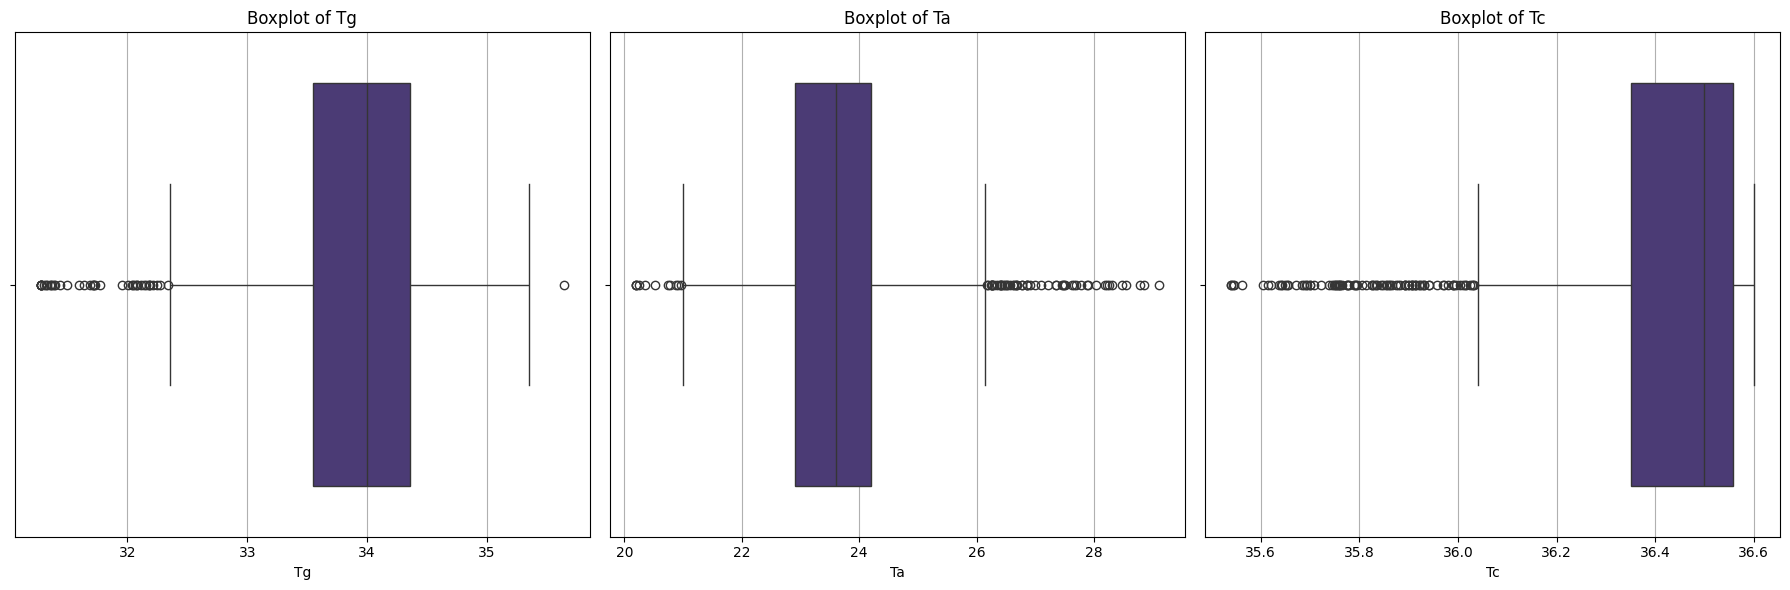

In [106]:
alt_outliers = outlier_analysis(altnt)

In [107]:
alt_outliers['Tg'][alt_outliers['Tg']['Tg'] < 32.35]

# Fail

,Tg,Ta,Tc
27,31.280845,21.829028,36.234320
295,31.725483,20.517466,35.752210
350,32.184883,20.203637,36.590000
776,31.280000,20.200000,35.540000
1166,31.771482,22.566771,36.272848
1646,32.178663,22.534115,36.526162
1936,32.111700,22.850883,36.204991
1968,32.084239,21.276264,36.475457
2039,31.711063,22.478049,36.267547
2342,31.280121,22.534211,36.368379


In [108]:
alt_outliers['Tc'][alt_outliers['Tc']['Tc'] < 36.04]

# Fail

,Tg,Ta,Tc
45,33.892749,24.192030,35.892571
115,34.208343,24.300000,35.825792
240,33.956517,22.891066,35.854745
295,31.725483,20.517466,35.752210
352,33.994685,22.699743,35.614444
...,...,...,...
9805,34.514555,22.622212,35.867114
9817,33.919194,23.500000,35.914314
9823,34.112290,23.556330,35.700355
9879,34.377287,22.009708,35.906569


In [109]:
modified_altnt = altnt[~altnt.index.isin(alt_outliers['Tg'][alt_outliers['Tg']['Tg'] < 32.35].index)]
modified_altnt = modified_altnt[~modified_altnt.index.isin(alt_outliers['Tc'][alt_outliers['Tc']['Tc'] < 36.04].index)]

### All (Exclude Outliers)

In [110]:
preprocessed_augmented_data = pd.concat([modified_altnt, modified_ant, modified_agtnt], ignore_index=True)

In [111]:
preprocessed_augmented_data

,Tg,Ta,Tc
0,34.649016,25.546500,36.459977
1,34.708238,23.005860,36.575389
2,33.266084,22.506536,36.243979
3,32.971951,23.200000,36.548970
4,34.325693,22.689721,36.526066
...,...,...,...
9849,34.888843,24.891839,37.240000
9850,34.685944,24.000000,37.772093
9851,34.078976,22.764650,37.374889
9852,35.401289,24.823869,37.767902


In [112]:
# preprocessed_augmented_data.to_csv("../data/interim/preprocessed_augmented_data.csv", index=False)

### Summary

In [128]:
summary = preprocessed_augmented_data.describe()
# Calculate skewness and kurtosis for each column
summary.loc['skew'] = preprocessed_augmented_data.skew()
summary.loc['kurtosis'] = preprocessed_augmented_data.kurtosis()

# Display the updated summary
summary

,Tg,Ta,Tc
count,9854.000000,9854.000000,9854.000000
mean,34.417280,24.110834,37.052614
std,0.630952,1.298131,0.514974
min,32.353511,20.200000,36.041187
25%,34.018333,23.400000,36.790000
50%,34.402126,24.000000,36.944182
75%,34.786092,24.700000,37.140000
max,37.212500,29.100000,40.340000
skew,0.408977,0.544388,2.244758
kurtosis,1.136782,1.434327,7.541294


In [116]:
dataframe_summary(preprocessed_augmented_data)


--- Dataframe Summary ---


,Data Type,Non-Null Count,Missing Values,Distinct Values,Zeros Count,Negative Values,Infinite Values
Tg,float64,9854,0,9851,0,0,0
Ta,float64,9854,0,6465,0,0,0
Tc,float64,9854,0,4885,0,0,0



--- Distribution Analysis ---

Normality Tests (Shapiro-Wilk):
{'Shapiro-Wilk Test': {'statistic': np.float64(0.9875667082375469), 'p/critical value': np.float64(1.3718010292929887e-20), 'normal': np.False_}, "D'Agostino's K^2 Test": {'statistic': np.float64(207.28124345350903), 'p/critical value': np.float64(9.76000146933477e-46), 'normal': np.False_}, 'Anderson-Darling Test': {'statistic': np.float64(9.912212421053482), 'p/critical value': np.float64(0.786), 'normal': False}, 'conclusion': np.False_}
  The distribution of Tg is likely not normal (p < 0.05)
{'Shapiro-Wilk Test': {'statistic': np.float64(0.9657276762767242), 'p/critical value': np.float64(6.74816143708798e-33), 'normal': np.False_}, "D'Agostino's K^2 Test": {'statistic': np.float64(365.77762102486), 'p/critical value': np.float64(3.735930536177984e-80), 'normal': np.False_}, 'Anderson-Darling Test': {'statistic': np.float64(60.56498681049379), 'p/critical value': np.float64(0.786), 'normal': False}, 'conclusion': np.F

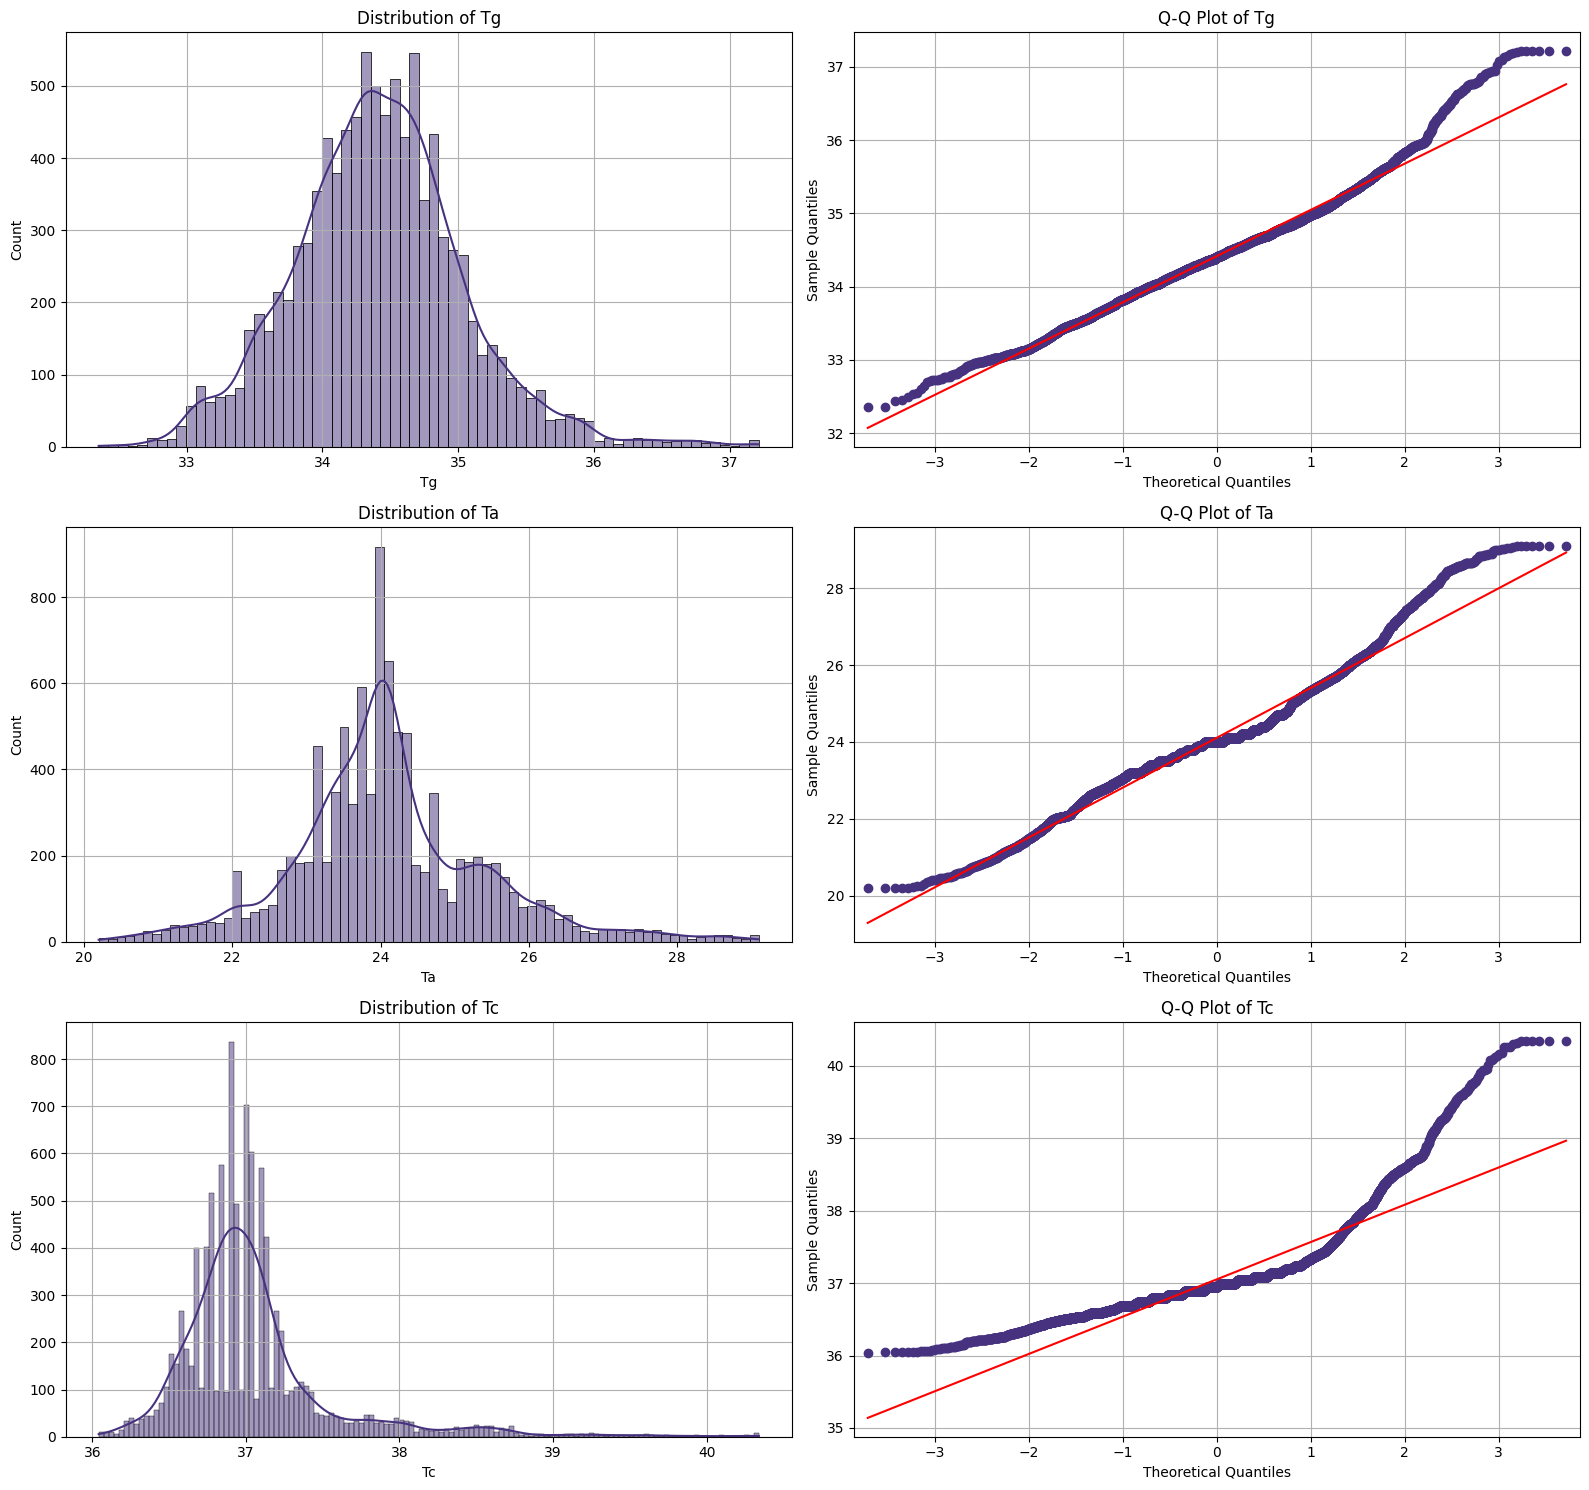

In [140]:
distribution_analysis(preprocessed_augmented_data, 'preprocessed', 'augmented')

## Correlation Analysis (Preprocessed Data)


### Preprocessed External Data

In [68]:
from eda import correlation_analysis_preprocess


--- Correlation Analysis on Preprocessed Dataset ---

Correlation Matrix on Preprocessed Dataset:
       Tg     Ta     Tc
Tg  1.000  0.381  0.601
Ta  0.381  1.000  0.093
Tc  0.601  0.093  1.000

Pearson Correlation Coefficients (Preprocessed):
Tg vs Tc: r = 0.6009, p-value = 4.1991e-194
  The correlation between Tg and Tc is statistically significant
Ta vs Tc: r = 0.0932, p-value = 3.3874e-05
  The correlation between Ta and Tc is statistically significant

Spearman Rank Correlation Coefficients (Preprocessed):
Tg vs Tc: rho = 0.4366, p-value = 1.0898e-92
Ta vs Tc: rho = 0.0964, p-value = 1.7821e-05


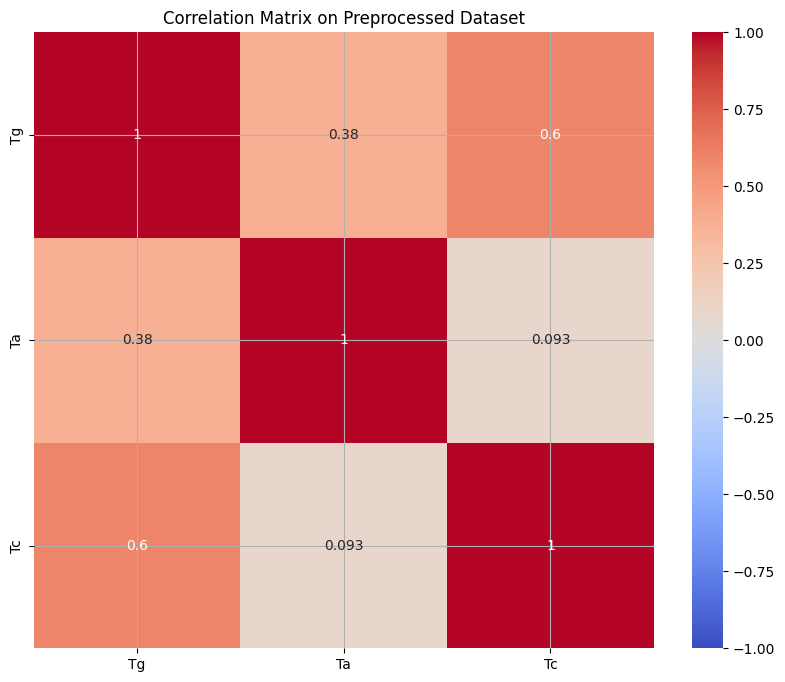

<Figure size 1500x1000 with 0 Axes>

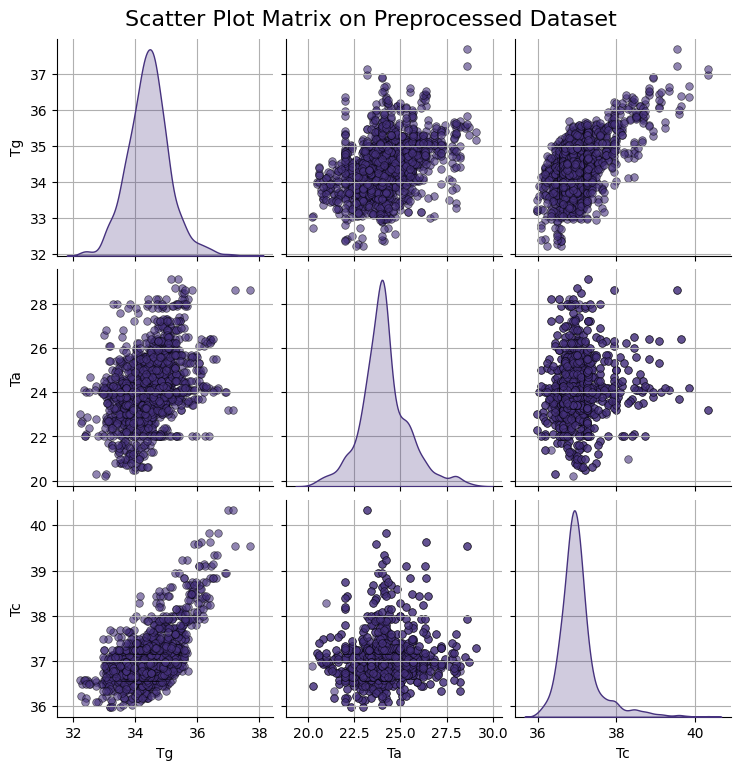

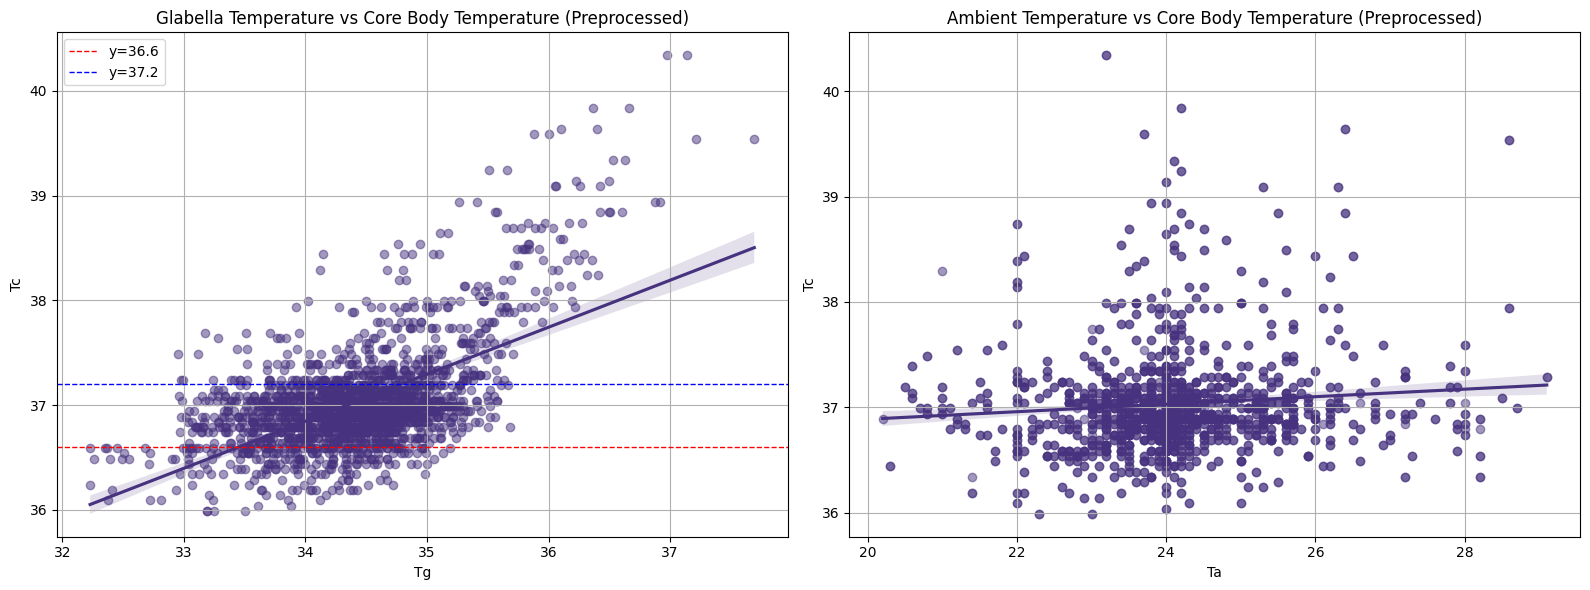

In [69]:
correlation_analysis_preprocess(save_preprocess_data, 'external')

### Preprocessed Augmented Data


--- Correlation Analysis on Preprocessed Dataset ---

Correlation Matrix on Preprocessed Dataset:
       Tg     Ta     Tc
Tg  1.000  0.389  0.586
Ta  0.389  1.000  0.091
Tc  0.586  0.091  1.000

Pearson Correlation Coefficients (Preprocessed):
Tg vs Tc: r = 0.5859, p-value = 0.0000e+00
  The correlation between Tg and Tc is statistically significant
Ta vs Tc: r = 0.0908, p-value = 1.6923e-19
  The correlation between Ta and Tc is statistically significant

Spearman Rank Correlation Coefficients (Preprocessed):
Tg vs Tc: rho = 0.4253, p-value = 0.0000e+00
Ta vs Tc: rho = 0.0885, p-value = 1.3224e-18


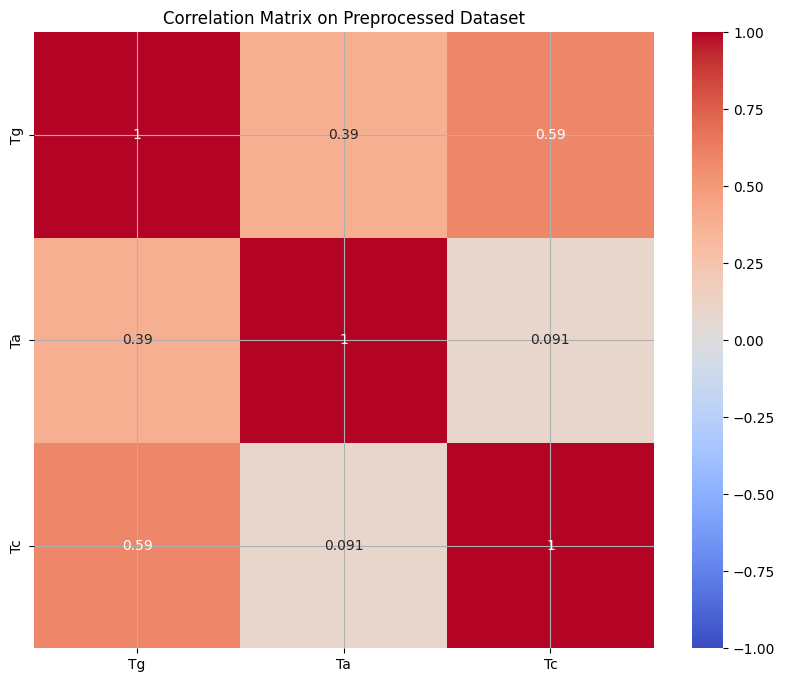

<Figure size 1500x1000 with 0 Axes>

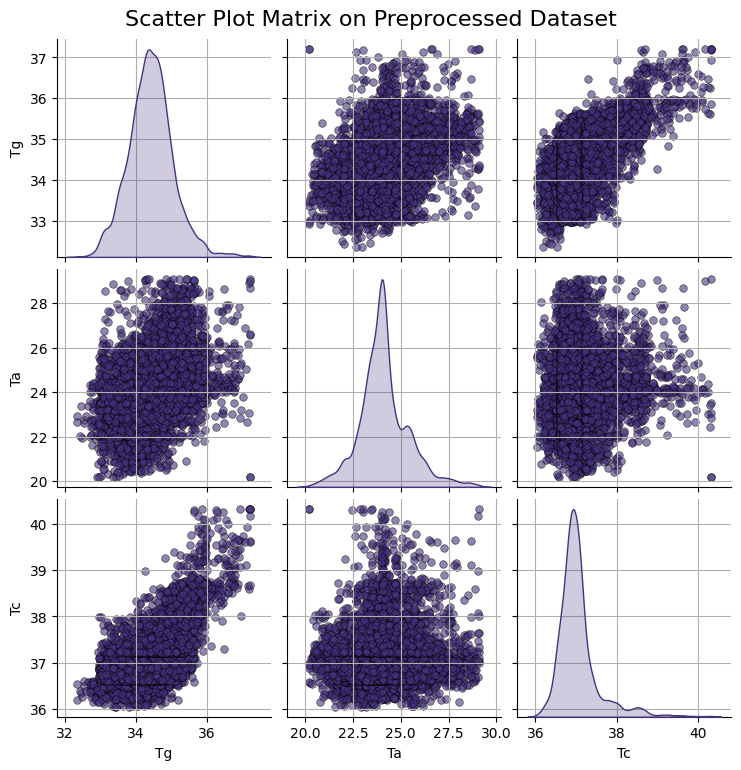

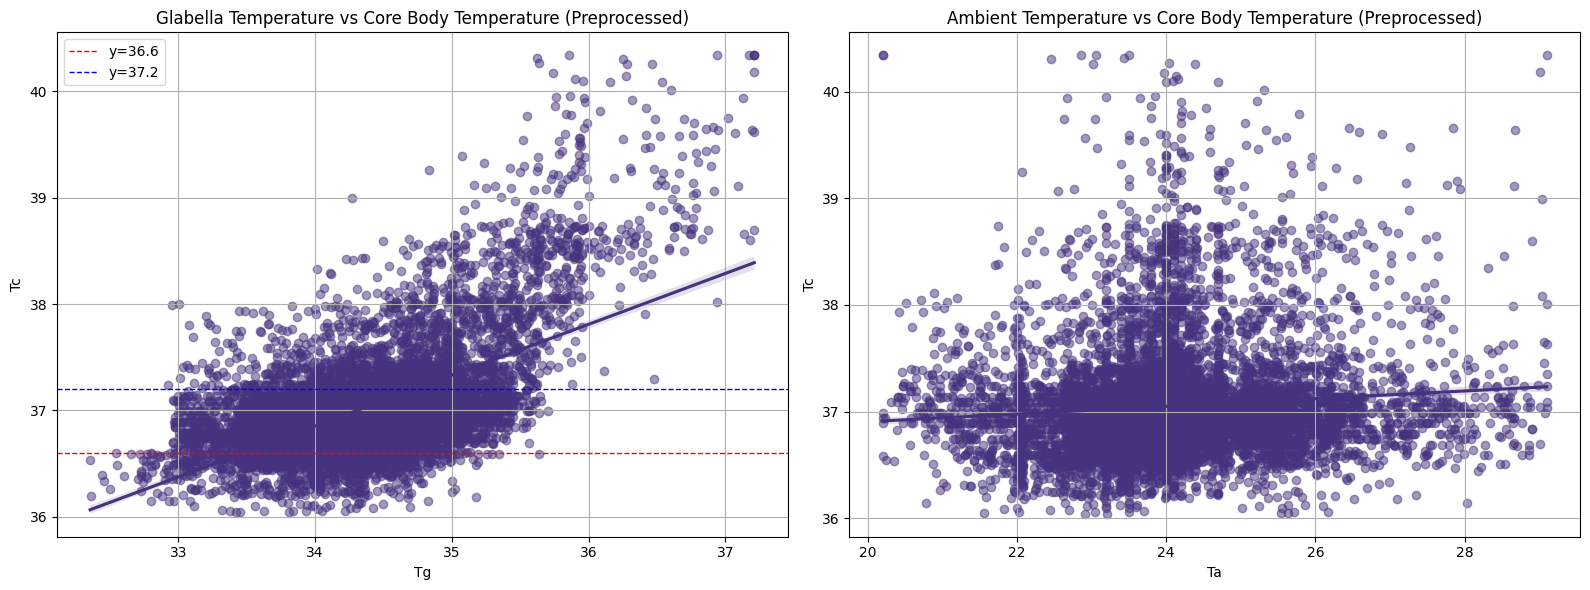

In [141]:
correlation_analysis_preprocess(preprocessed_augmented_data, 'augmented')